# Histograms
Here we compare performance of histograms implemented in [cupy](https://cupy.dev), [numpy](https://numpy.org) and [pyclEsperanto](https://github.com/clEsperanto/pyclesperanto_prototype).

**Note:** benchmarking results vary heavily depending on image size, kernel size, used operations, parameters and used hardware. Use this notebook to adapt it to your use-case scenario and benchmark on your target hardware. If you have different scenarios or use-cases, you are very welcome to submit your notebook as pull-request!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle

# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('RTX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [2]:
from skimage.io import imshow
image = np.random.normal(size=(100,1024,1024))

(100, 1024, 1024)

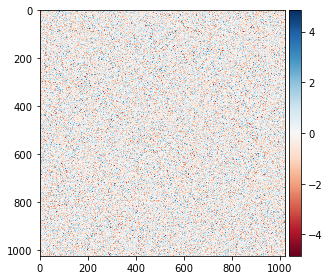

In [3]:
imshow(image[60])
image.shape

## cupy

cupy histogram duration: 0.7032649517059326
cupy histogram duration: 0.5831310749053955
cupy histogram duration: 0.5701284408569336
cupy histogram duration: 0.5831310749053955
cupy histogram duration: 0.5702309608459473
cupy histogram duration: 0.5833230018615723
cupy histogram duration: 0.5712060928344727
cupy histogram duration: 0.5841319561004639
cupy histogram duration: 0.5711276531219482
cupy histogram duration: 0.5823707580566406


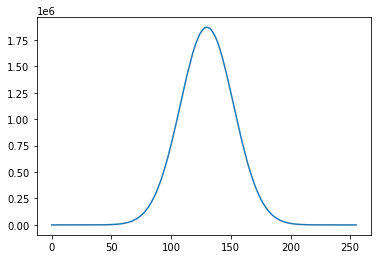

In [4]:
import time
import cupy

cuda_image = cupy.asarray(image)

for i in range(0, 10):
    start_time = time.time()
    cuda_hist, _ = cupy.histogram(cuda_image, bins=256)
    cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
    print("cupy histogram duration: " + str(time.time() - start_time))
          
result = cupy.asnumpy(cuda_hist)
plt.plot(result)

## clEsperanto

clEsperanto histogram duration: 0.16014671325683594
clEsperanto histogram duration: 0.13502955436706543
clEsperanto histogram duration: 0.1360311508178711
clEsperanto histogram duration: 0.13503122329711914
clEsperanto histogram duration: 0.13524127006530762
clEsperanto histogram duration: 0.1360306739807129
clEsperanto histogram duration: 0.1360311508178711
clEsperanto histogram duration: 0.1400308609008789
clEsperanto histogram duration: 0.13703083992004395
clEsperanto histogram duration: 0.13611841201782227


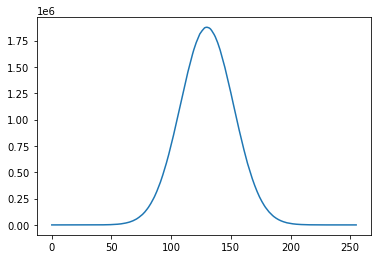

In [5]:
ocl_image = cle.push(image)

for i in range(0, 10):
    start_time = time.time()
    ocl_hist = cle.histogram(ocl_image, num_bins=256)
    print("clEsperanto histogram duration: " + str(time.time() - start_time))

result = cle.pull(ocl_hist)
plt.plot(result)

## Numpy

numpy histogram duration: 0.9113967418670654
numpy histogram duration: 0.9012026786804199
numpy histogram duration: 0.9092044830322266
numpy histogram duration: 0.9033567905426025
numpy histogram duration: 0.9126231670379639
numpy histogram duration: 0.9033560752868652
numpy histogram duration: 0.9123461246490479
numpy histogram duration: 0.9022026062011719
numpy histogram duration: 0.9096465110778809
numpy histogram duration: 0.9023604393005371


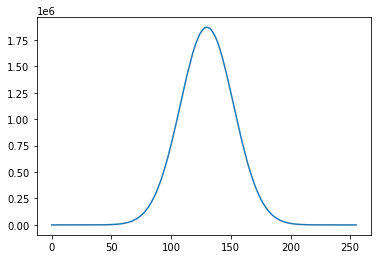

In [6]:
import time
from scipy import ndimage as sndi


for i in range(0, 10):
    start_time = time.time()
    np_hist, _ = np.histogram(image, bins=256)
    print("numpy histogram duration: " + str(time.time() - start_time))

result = np_hist
plt.plot(result)

# Histogram duration depends on array size
We will now benchmark how long computation of histogram including data transfer takes depending on different image sizes.

In [7]:
sizes = [1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128]
mb_per_pixel = 4 # we're working with 32-bit float pixels (4 bytes)
sizes_mb = np.asarray(sizes) * mb_per_pixel

num_iterations = 2

np_times = []
cl_times = []
cu_times = []

for i in range(0, num_iterations):
    for size in sizes:
        image = np.random.normal(size=(size,1024,1024))

        # clesperanto
        start_time = time.time()
        ocl_hist = cle.histogram(image, num_bins=256)
        cl_times.append(time.time() - start_time)

        # cupy
        start_time = time.time()
        cuda_image = cupy.asarray(image)
        cuda_hist, _ = cupy.histogram(cuda_image, bins=256)
        cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
        cu_times.append(time.time() - start_time)

        # numpy
        start_time = time.time()
        np_hist, _ = np.histogram(image, bins=256)
        np_times.append(time.time() - start_time)

np_times = np.reshape(np_times, (num_iterations, len(sizes_mb)))
cl_times = np.reshape(cl_times, (num_iterations, len(sizes_mb)))
cu_times = np.reshape(cu_times, (num_iterations, len(sizes_mb)))

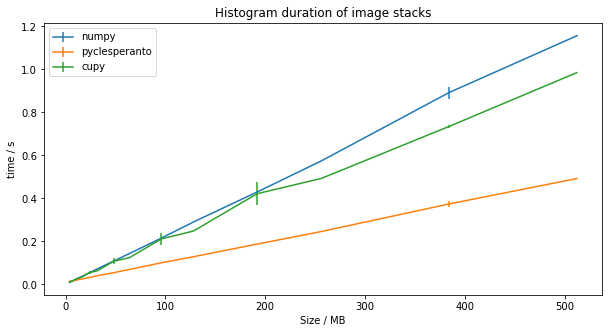

In [8]:
plt.figure(figsize=(10,5))
plt.errorbar(sizes_mb, np_times.mean(axis=0), yerr=np_times.std(axis=0))
plt.errorbar(sizes_mb, cl_times.mean(axis=0), yerr=cl_times.std(axis=0))
plt.errorbar(sizes_mb, cu_times.mean(axis=0), yerr=cu_times.std(axis=0))
plt.title("Histogram duration of image stacks")
plt.xlabel("Size / MB")
plt.ylabel("time / s")
plt.legend(["numpy", "pyclesperanto", "cupy"])
plt.show()